In [12]:
import sys,os
sys.path.append(os.path.abspath("../../"))
sys.path.append(os.path.abspath('../../modules/'))
import healpy as h
from astropy.io import fits

from modules.masking import gen_masks as gm
from modules.settings import global_mmf_settings as gset
from filters import modular_multi_matched_filter_v1 as mmf
from simulate import simulate_multi_channel_cluster as smcc
from modules.flat_sky_codes import flat_sky_analysis as fsa
from modules.data_preprocess import get_tangent_planes as gtp
from modules.flat_sky_codes import tangent_plane_analysis as tpa
from modules.data_preprocess import preprocess_planck_psm_data_esz_cat as ppd
from simulate import cluster_templates as cltemp

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
def colorbar(mappable):
	ax = mappable.axes
	fig = ax.figure
	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="5%", pad=0.05)
	return fig.colorbar(mappable, cax=cax)


def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

figpath="./results/mmf_results_170221/"

ensure_dir(figpath)
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [13]:
dataset="planck_psm_sim"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=False
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

outpath=figpath + dataset + "/planck_cat_" + dir_suffix + "/"
tempdatapath=figpath + "/tempdata/" + dataset + "/planck_tiles/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=False,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
datapath=gset.mmfset.paths["result_data"]

emask=gm.return_edge_apodized_mask(edge_width=30,fwhm=30)

In [14]:
# ppd.extract_tangent_planes(gen_mask=True,verbose=False,do_data=True,do_mask=True)

In [15]:
xsz_cat=ppd.get_tangent_plane_fnames()

In [16]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_step=1.,theta500_min=2.,theta500_max=40.,theta_step=2.)
tmplt.setup_templates()
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [17]:
noise=gtp.return_data(xsz_cat["FILENAME"][1])
clst,Tc,thetac=smcc.return_mc_cluster(5,0.1,tmplt,y0=2e-4,cold=True)
data=clst + noise

<IPython.core.display.Javascript object>


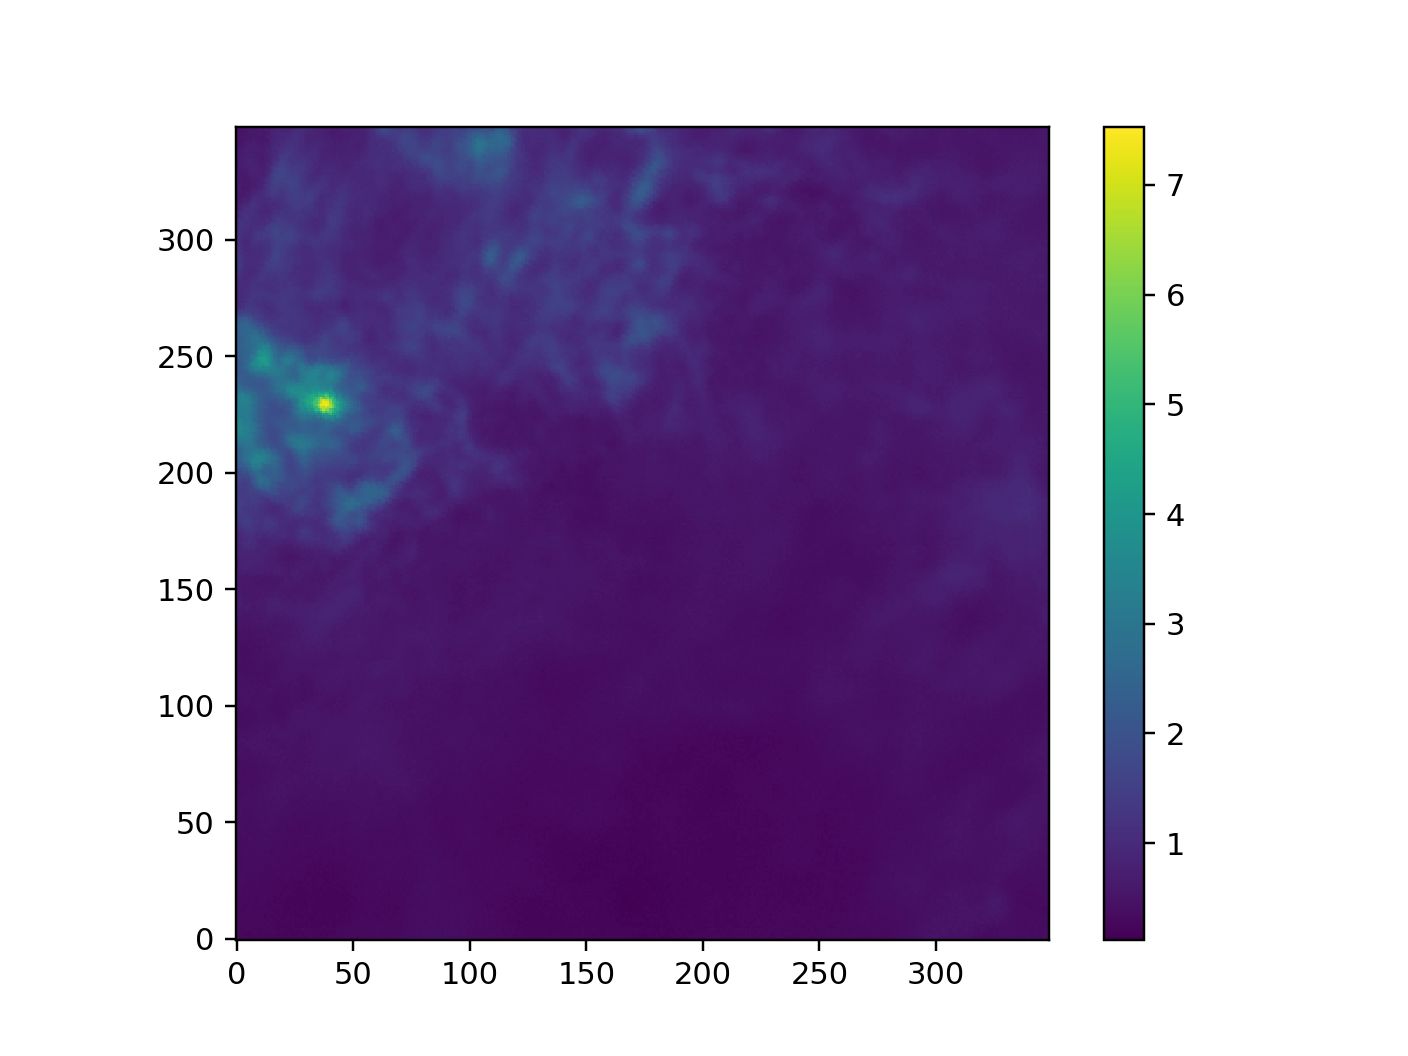

<IPython.core.display.Javascript object>

In [18]:
figure()
imshow(data[5,],origin="lower")
colorbar()

figure()
imshow(clst[0,],origin="lower")
colorbar()

In [19]:
op.get_data_ft(data*emask,emask=emask)

In [20]:
fdata,err,snr,yc=op.return_snr(thetac=thetac,Tc=0.)
print yc,snr

0.0002024670774078502 36.9370608476335


In [21]:
fdata,err,snr,yc=op.return_snr(thetac=tmplt.theta500[5],Tc=0.)
print yc,snr

0.00016357326416104414 37.27068657610239


In [29]:
gset.mmfset.channels

array([100., 143., 217., 353., 545., 857.])